## Tacotron 2 inference code 
Edit the variables **checkpoint_path** and **text** to match yours and run the entire code to generate plots of mel outputs, alignments and audio synthesis from the generated mel-spectrogram using Griffin-Lim.

#### Import libraries and setup matplotlib

In [2]:
pip install -r /kaggle/input/tacotron/requirements.txt  

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 kB 814.6 kB/s eta 0:00:00 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 8.7 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 60.8 MB/s eta 0:00:0000:01:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.0/59.0 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.4/235.4 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 68.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 82.0 MB/s eta 0:00:00:00:01
  Created wheel for librosa: filename=librosa-0.6.0-py3-none-any.whl size=1553465 sha256=a732503de570fca364189d2748fa44038832adb753f20c41dca92ab749147246
  Stored in directory: /root/.cache/pip/wheels/8e/d9/7b/6239ea4300d05735c3d0f1a2f9f2351fe4cb34f393eb3b95ef
Successfully built librosa
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Unins

In [18]:
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt

import IPython.display as ipd

import sys
sys.path.append('/kaggle/input/tacotrontrainmodel/')
import numpy as np
import torch

from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT, STFT
from audio_processing import griffin_lim
from train import load_model
from text import text_to_sequence
sys.path.append('/kaggle/input/tacotrontrainmodel/waveglow')
from denoiser import Denoiser

In [19]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='upper', 
                       interpolation='none')

#### Setup hparams

In [20]:
hparams = create_hparams()
hparams.sampling_rate = 16000

#### Load model from checkpoint

In [21]:
checkpoint_path = "/kaggle/working/Output/checkpoint_10000"
model = load_model(hparams)
model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
_ = model.cuda().eval()

#### Load WaveGlow for mel2audio synthesis and denoiser

In [22]:
waveglow_path = '/kaggle/input/pretrainedmodel/waveglow_256channels_universal_v5.pt'
waveglow = torch.load(waveglow_path)['model']
waveglow.cuda().eval()
for k in waveglow.convinv:
    k.float()
denoiser = Denoiser(waveglow)

Enters here....


#### Prepare text input

In [26]:
text = "நா"
sequence = np.array(text_to_sequence(text, ['dummy_cleaners']))[None, :]
sequence = torch.autograd.Variable(
    torch.from_numpy(sequence)).cuda().long()

text_to_sequence [244] நா


#### Decode text input and plot results

Warning! Reached max decoder steps


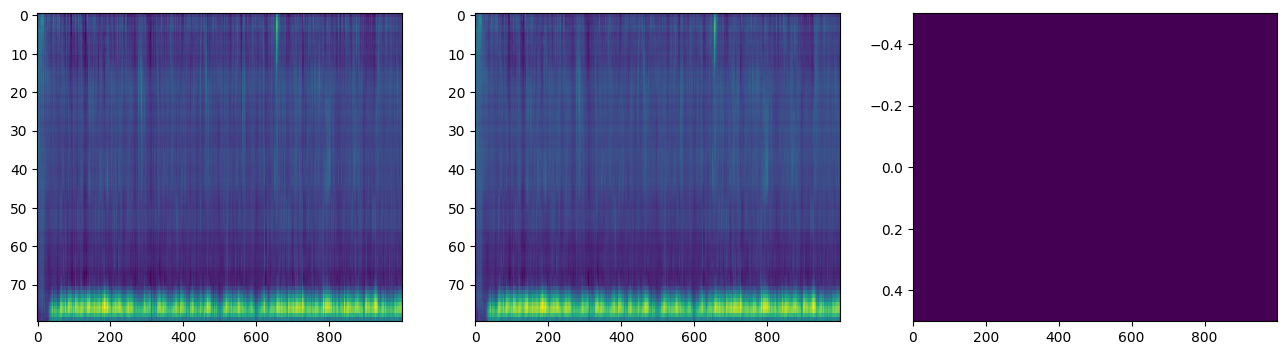

In [27]:
mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
plot_data((mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))

#### Synthesize audio from spectrogram using WaveGlow

In [28]:
with torch.no_grad():
    audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)

#### (Optional) Remove WaveGlow bias

In [9]:
audio_denoised = denoiser(audio, strength=0.01)[:, 0]
ipd.Audio(audio_denoised.cpu().numpy(), rate=hparams.sampling_rate) 

TypeError: pad_center() takes 1 positional argument but 2 were given